# 0. Imports & functions

In [1]:
import sys
import os

sys.path.append("../")

In [2]:
from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/telco_churn.csv")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()

NameError: name 'to_snake_case' is not defined

In [3]:
y = "customer_status"

# some generic cleaning
df["avg_monthly_long_distance_charges"] = df["avg_monthly_long_distance_charges"].fillna(
    0.0)
df["multiple_lines"] = df["multiple_lines"].fillna('no phone service')
df["avg_monthly_gb_download"] = df["avg_monthly_gb_download"].fillna(0)
no_internet = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
               'streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet] = df[no_internet].fillna('no internet service')
COLUMNS_TO_DROP = ["customer_id", "churn_category",
                   "churn_reason", "longitude", "latitude", "city"]
df = df[df[y] != "Joined"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

# 2. Model selection

## Logistic Regression

In [4]:
param_grid_log_reg = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000]
}

model = LogisticRegression()

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid_model=param_grid_log_reg)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best score: 0.9140680575463185
Best parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'pca__n_components': 50}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                                                  ['gender', 'married', 'offer',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'internet_type',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection_plan',
                                                   'premium_tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'streaming_music',
                                                   'unlimited_data', 'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('pca', PCA(n_components=50)),
                ('logistic', LogisticRegression(C=100))])

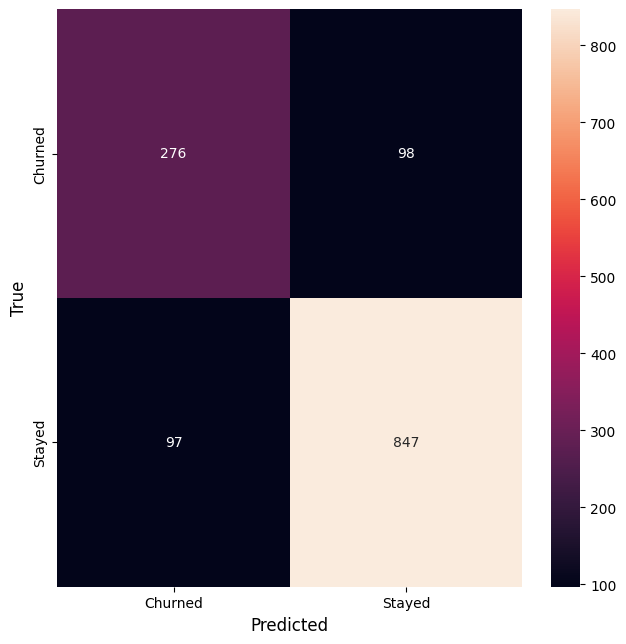

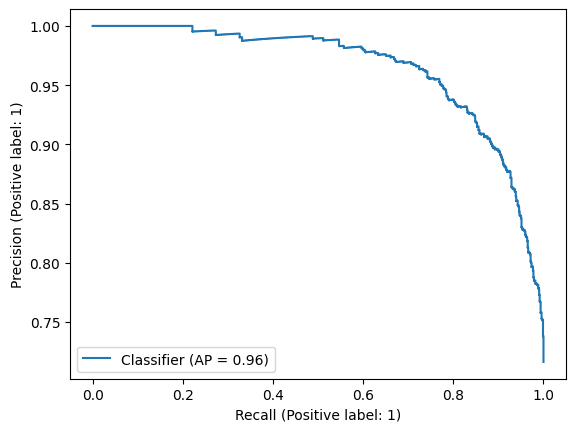

In [5]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y)

In [31]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5]
}

xgb = XGBClassifier()

grid, le = sklearn_gridsearch_using_pipeline(
    train, y_name=y, model_name="xgb", model=xgb, param_grid=param_grid_xgb)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

[CV 2/5] END pca__n_components=25, xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6;, score=0.905 total time=   3.0s
[CV 3/5] END pca__n_components=25, xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6;, score=0.901 total time=   2.9s
[CV 4/5] END pca__n_components=25, xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6;, score=0.890 total time=   2.7s
[CV 5/5] END pca__n_components=25, xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.6;, score=0.896 total time=   3.2s
[CV 1/5] END pca__n_components=25, xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8;, score=0.917 total time=   3.9s
[CV 4/5] END pca__n_components=25, xgb__colsample_bytree=1.0, xgb__gamma=2, xgb__max_depth=5, xgb__min_child_weight=1, xgb__subsample=0.8;, score

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'number_of_dependents',
                                                   'zip_code',
                                                   'number_of_referrals',
                                                   'tenure_in_months',
                                                   'avg_monthly_long_distance_charges',
                                                   'avg_monthly_gb_download',
                                                   'monthly_charge',
                                                   'total_charges',
                                                   'total_...
                               feature_types=None, gamma=5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [ ]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y)

# 3. Cost-based evaluation

In [22]:
df['A'] = df['monthlycharge']

# Step 2: Define a function to calculate the instance-dependent cost


def instance_dependent_cost(predicted_label, true_label, A):
    if true_label == 1 and predicted_label == 1:  # True Positive (TP)
        return 0
    elif true_label == 0 and predicted_label == 1:  # False Positive (FP)
        return 2 * A
    elif true_label == 0 and predicted_label == 0:  # True Negative (TN)0
        return 0
    elif true_label == 1 and predicted_label == 0:  # False Negative (FN)
        return 12 * A


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
df['instance_cost'] = df.apply(lambda row: instance_dependent_cost(
    row['predicted_labels'], row['true_labels'], row['A']), axis=1)

# Print the DataFrame with the instance-dependent cost matrix
print(df[['monthlycharge', 'predicted_labels', 'true_labels', 'instance_cost']])

KeyError: 'predicted_labels'

In [258]:
X_train = np.array([[...], [...], ...])  # Replace '...' with your actual features

# Example binary target labels
y_train = np.array([0, 1, 1, 0])  # Replace with your actual target labels

# Create a list to store instance-dependent predicted probabilities (X values)
instance_probs = []

# Train a logistic regression model for each instance and get the predicted probabilities
for i in range(len(X_train)):
    # Select the i-th instance as a single-sample training set
    X_single_instance = X_train[i].reshape(1, -1)
    y_single_instance = y_train[i]

    # Create a logistic regression model
    model = LogisticRegression()

    # Fit the model to the single-instance data
    model.fit(X_single_instance, [y_single_instance])

    # Predict the probability for class 1 (positive class)
    prob_class_1 = model.predict_proba(X_single_instance)[:, 1]

    # Append the predicted probability to the list
    instance_probs.append(prob_class_1[0])

# Convert the list to a numpy array
X_predicted_probs = np.array(instance_probs)

# Now, X_predicted_probs contains the instance-dependent predicted probabilities (X values)
print("Instance-Dependent Predicted Probabilities (X):", X_predicted_probs)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [256]:
def cross_entropy_cost(hypothesis, y_true):
    # Ensure the hypothesis values are clipped to avoid taking the logarithm of zero
    epsilon = 1e-15
    hypothesis = np.clip(hypothesis, epsilon, 1 - epsilon)

    # Calculate the cross-entropy cost
    cost = -np.mean(y_true * np.log(hypothesis) + (1 - y_true) * np.log(1 - hypothesis))
    return cost




In [257]:
y_true = np.array([0, 1, 1, 0])
instance_costs = [cross_entropy_cost(X[i], y_true[i]) for i in range(len(X))]

IndexError: index 4 is out of bounds for axis 0 with size 4